<a href="https://colab.research.google.com/github/riphunter7001x/Fine-tune-Embedding-models/blob/main/Fine_tune_Embedding_models_for_Retrieval_Augmented_Generation_(RAG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Pytorch & other libraries
!pip install transformers[torch]
!pip install -U sentence-transformers
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 8.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from huggingface_hub import notebook_login

notebook_login()

1. Create & Prepare embedding dataset

In [3]:
from datasets import load_dataset

# Load dataset from the hub
dataset = load_dataset("philschmid/finanical-rag-embedding-dataset", split="train")

# rename columns
dataset = dataset.rename_column("question", "anchor")
dataset = dataset.rename_column("context", "positive")

# Add an id column to the dataset
dataset = dataset.add_column("id", range(len(dataset)))

# split dataset into a 10% test set
dataset = dataset.train_test_split(test_size=0.1)

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/7000 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

243505

In [7]:
import torch
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("BAAI/bge-base-en")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2. Create baseline and evaluate pretrained model

In [8]:
import torch
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import (
    InformationRetrievalEvaluator,
    SequentialEvaluator,
)
from sentence_transformers.util import cos_sim
from datasets import load_dataset, concatenate_datasets

model_id = "BAAI/bge-base-en"  # Hugging Face model ID
matryoshka_dimensions = [768, 512, 256, 128, 64] # Important: large to small

# Load a model
model = SentenceTransformer(
    model_id, device="cuda" if torch.cuda.is_available() else "cpu"
)

# load test dataset
test_dataset = load_dataset("json", data_files="test_dataset.json", split="train")
train_dataset = load_dataset("json", data_files="train_dataset.json", split="train")
corpus_dataset = concatenate_datasets([train_dataset, test_dataset])

# Convert the datasets to dictionaries
corpus = dict(
    zip(corpus_dataset["id"], corpus_dataset["positive"])
)  # Our corpus (cid => document)
queries = dict(
    zip(test_dataset["id"], test_dataset["anchor"])
)  # Our queries (qid => question)

# Create a mapping of relevant document (1 in our case) for each query
relevant_docs = {}  # Query ID to relevant documents (qid => set([relevant_cids])
for q_id in queries:
    relevant_docs[q_id] = [q_id]


matryoshka_evaluators = []
# Iterate over the different dimensions
for dim in matryoshka_dimensions:
    ir_evaluator = InformationRetrievalEvaluator(
        queries=queries,
        corpus=corpus,
        relevant_docs=relevant_docs,
        name=f"dim_{dim}",
        truncate_dim=dim,  # Truncate the embeddings to a certain dimension
        score_functions={"cosine": cos_sim},
    )
    matryoshka_evaluators.append(ir_evaluator)

# Create a sequential evaluator
evaluator = SequentialEvaluator(matryoshka_evaluators)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
# Evaluate the model
results = evaluator(model)

# print(results)

# Print the main score
for dim in matryoshka_dimensions:
    key = f"dim_{dim}_cosine_ndcg@10"
    print
    print(f"{key}: {results[key]}")

dim_768_cosine_ndcg@10: 0.7482943303571971
dim_512_cosine_ndcg@10: 0.7465848923504599
dim_256_cosine_ndcg@10: 0.7334252643509824
dim_128_cosine_ndcg@10: 0.7023428587039997
dim_64_cosine_ndcg@10: 0.6352052504515721


3. Define loss function with Matryoshka Representation

In [10]:
from sentence_transformers import SentenceTransformerModelCardData, SentenceTransformer

# Hugging Face model ID: https://huggingface.co/BAAI/bge-base-en-v1.5
model_id = "BAAI/bge-base-en"

# load model with SDPA for using Flash Attention 2
model = SentenceTransformer(
    model_id,
    model_kwargs={"attn_implementation": "sdpa"},
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name="BGE base Financial Matryoshka",
    ),
)

In [11]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]  # Important: large to small
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

4. Fine-tune embedding model with SentenceTransformersTrainer

In [12]:
from sentence_transformers import SentenceTransformerTrainer, SentenceTransformerTrainingArguments
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

In [13]:
# 3. Define a loss function
loss = MultipleNegativesRankingLoss(model)


In [14]:

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="bge-base-financial",
    # Optional training parameters:
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="bge-base-financial",  # Will be used in W&B if `wandb` is installed
)

In [15]:
# load train dataset again
train_dataset = load_dataset("json", data_files="train_dataset.json", split="train")

In [16]:
from sentence_transformers import SentenceTransformerTrainer

trainer = SentenceTransformerTrainer(
    model=model, # bg-base-en
    args=args,  # training arguments
    train_dataset=train_dataset.select_columns(
        ["positive", "anchor"]
    ),  # training dataset
    loss=train_loss,
    evaluator=evaluator,
)


In [17]:
# start training, the model will be automatically saved to the hub and the output directory
trainer.train()

Step,Training Loss,Validation Loss,Dim 768 Cosine Accuracy@1,Dim 768 Cosine Accuracy@3,Dim 768 Cosine Accuracy@5,Dim 768 Cosine Accuracy@10,Dim 768 Cosine Precision@1,Dim 768 Cosine Precision@3,Dim 768 Cosine Precision@5,Dim 768 Cosine Precision@10,Dim 768 Cosine Recall@1,Dim 768 Cosine Recall@3,Dim 768 Cosine Recall@5,Dim 768 Cosine Recall@10,Dim 768 Cosine Ndcg@10,Dim 768 Cosine Mrr@10,Dim 768 Cosine Map@100,Dim 512 Cosine Accuracy@1,Dim 512 Cosine Accuracy@3,Dim 512 Cosine Accuracy@5,Dim 512 Cosine Accuracy@10,Dim 512 Cosine Precision@1,Dim 512 Cosine Precision@3,Dim 512 Cosine Precision@5,Dim 512 Cosine Precision@10,Dim 512 Cosine Recall@1,Dim 512 Cosine Recall@3,Dim 512 Cosine Recall@5,Dim 512 Cosine Recall@10,Dim 512 Cosine Ndcg@10,Dim 512 Cosine Mrr@10,Dim 512 Cosine Map@100,Dim 256 Cosine Accuracy@1,Dim 256 Cosine Accuracy@3,Dim 256 Cosine Accuracy@5,Dim 256 Cosine Accuracy@10,Dim 256 Cosine Precision@1,Dim 256 Cosine Precision@3,Dim 256 Cosine Precision@5,Dim 256 Cosine Precision@10,Dim 256 Cosine Recall@1,Dim 256 Cosine Recall@3,Dim 256 Cosine Recall@5,Dim 256 Cosine Recall@10,Dim 256 Cosine Ndcg@10,Dim 256 Cosine Mrr@10,Dim 256 Cosine Map@100,Dim 128 Cosine Accuracy@1,Dim 128 Cosine Accuracy@3,Dim 128 Cosine Accuracy@5,Dim 128 Cosine Accuracy@10,Dim 128 Cosine Precision@1,Dim 128 Cosine Precision@3,Dim 128 Cosine Precision@5,Dim 128 Cosine Precision@10,Dim 128 Cosine Recall@1,Dim 128 Cosine Recall@3,Dim 128 Cosine Recall@5,Dim 128 Cosine Recall@10,Dim 128 Cosine Ndcg@10,Dim 128 Cosine Mrr@10,Dim 128 Cosine Map@100,Dim 64 Cosine Accuracy@1,Dim 64 Cosine Accuracy@3,Dim 64 Cosine Accuracy@5,Dim 64 Cosine Accuracy@10,Dim 64 Cosine Precision@1,Dim 64 Cosine Precision@3,Dim 64 Cosine Precision@5,Dim 64 Cosine Precision@10,Dim 64 Cosine Recall@1,Dim 64 Cosine Recall@3,Dim 64 Cosine Recall@5,Dim 64 Cosine Recall@10,Dim 64 Cosine Ndcg@10,Dim 64 Cosine Mrr@10,Dim 64 Cosine Map@100,Sequential Score
100,2.421900,No log,0.677143,0.807143,0.850000,0.897143,0.677143,0.269048,0.170000,0.089714,0.677143,0.807143,0.850000,0.897143,0.787680,0.752608,0.756091,0.681429,0.814286,0.845714,0.900000,0.681429,0.271429,0.169143,0.090000,0.681429,0.814286,0.845714,0.900000,0.790176,0.755104,0.758200,0.678571,0.804286,0.848571,0.890000,0.678571,0.268095,0.169714,0.089000,0.678571,0.804286,0.848571,0.890000,0.784284,0.750426,0.754178,0.652857,0.778571,0.828571,0.872857,0.652857,0.259524,0.165714,0.087286,0.652857,0.778571,0.828571,0.872857,0.762986,0.727768,0.731982,0.602857,0.750000,0.802857,0.854286,0.602857,0.250000,0.160571,0.085429,0.602857,0.750000,0.802857,0.854286,0.728431,0.688159,0.692934,0.692934
200,0.468000,No log,0.680000,0.808571,0.841429,0.897143,0.680000,0.269524,0.168286,0.089714,0.680000,0.808571,0.841429,0.897143,0.788315,0.753649,0.756939,0.680000,0.808571,0.845714,0.895714,0.680000,0.269524,0.169143,0.089571,0.680000,0.808571,0.845714,0.895714,0.788541,0.754222,0.757420,0.677143,0.804286,0.844286,0.882857,0.677143,0.268095,0.168857,0.088286,0.677143,0.804286,0.844286,0.882857,0.782577,0.750143,0.754263,0.651429,0.785714,0.834286,0.878571,0.651429,0.261905,0.166857,0.087857,0.651429,0.785714,0.834286,0.878571,0.766512,0.730389,0.734350,0.611429,0.767143,0.807143,0.857143,0.611429,0.255714,0.161429,0.085714,0.611429,0.767143,0.807143,0.857143,0.737637,0.698986,0.704351,0.704351
300,0.315900,No log,0.697143,0.820000,0.860000,0.902857,0.697143,0.273333,0.172000,0.090286,0.697143,0.820000,0.860000,0.902857,0.800767,0.768084,0.771315,0.701429,0.820000,0.862857,0.901429,0.701429,0.273333,0.172571,0.090143,0.701429,0.820000,0.862857,0.901429,0.803120,0.771476,0.774912,0.691429,0.821429,0.858571,0.897143,0.691429,0.273810,0.171714,0.089714,0.691429,0.821429,0.858571,0.897143,0.797821,0.765724,0.769134,0.677143,0.812857,0.858571,0.887143,0.677143,0.270952,0.171714,0.088714,0.677143,0.812857,0.858571,0.887143,0.785831,0.752861,0.756909,0.642857,0.788571,0.834286,0.875714,0.642857,0.262857,0.166857,0.087571,0.642857,0.788571,0.834286,0

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=3940, training_loss=0.10767061654478312, metrics={'train_runtime': 2937.9009, 'train_samples_per_second': 21.444, 'train_steps_per_second': 1.341, 'total_flos': 0.0, 'train_loss': 0.10767061654478312, 'epoch': 10.0})

In [18]:
# save the best model
trainer.save_model()

# push model to hub
trainer.model.push_to_hub("bge-base-financial")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

'https://huggingface.co/riphunter7001x/bge-base-financial/commit/8183a6644b674a8ed6c3bdb0daaa0cb3248d1ccd'

5. Evaluate fine-tuned model against baseline

In [19]:
from sentence_transformers import SentenceTransformer

fine_tuned_model = SentenceTransformer(
    args.output_dir, device="cuda" if torch.cuda.is_available() else "cpu"
)
# Evaluate the model
results = evaluator(fine_tuned_model)

# print(results)

# Print the main score
for dim in matryoshka_dimensions:
    key = f"dim_{dim}_cosine_ndcg@10"
    print(f"{key}: {results[key]}")

dim_768_cosine_ndcg@10: 0.8107913505895344
dim_512_cosine_ndcg@10: 0.8091205169303904
dim_256_cosine_ndcg@10: 0.805047412303814
dim_128_cosine_ndcg@10: 0.7988401230276603
dim_64_cosine_ndcg@10: 0.780381780541374


result

Before Fine Tuning(Base model)

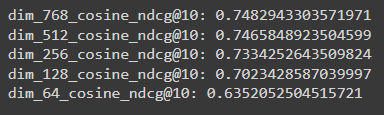

after fine tuning

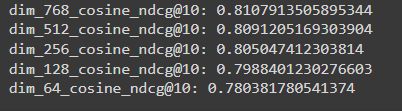